In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import evaluate
import gensim
import transformers
import nltk
import torch_geometric
import json
from xml.dom import minidom
from tqdm import tqdm

from modeling import testModel

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

c:\Users\wangz\anaconda3\envs\sp\lib\site-packages\torch\onnx\_internal\_beartype.py:35: UserWarning: module 'beartype.roar' has no attribute 'BeartypeDecorHintPep585DeprecationWarning'
  warnings.warn(f"{e}")


In [2]:
# This cell makes sure modules are auto-loaded when you change external python files
%load_ext autoreload
%autoreload 2

In [3]:
def read_svg_string(svg_strings):
    edge_list = []
    edge_index = []
    ps = 0
    pe = 0

    panel_list = []

    for i in svg_strings:
        ps = pe
        tmp = i.split()
        prev_x = float(tmp[1])
        prev_y = float(tmp[2])
        j = 3
        while j < len(tmp):
            edge = [prev_x, prev_y]
            if tmp[j] == 'z':
                break

            if tmp[j] == 'L':
                edge.append(float(tmp[j+1]))
                edge.append(float(tmp[j+2]))
                prev_x = float(tmp[j+1])
                prev_y = float(tmp[j+2])
                edge.append((edge[0] + edge[2]) / 2)
                edge.append((edge[1] + edge[3]) / 2)
                j = j + 3
                pe += 1
                edge_list.append(edge)
                continue
            if tmp[j] == 'Q':
                prev_x = float(tmp[j+3])
                prev_y = float(tmp[j+4])
                edge.append(float(tmp[j+3]))
                edge.append(float(tmp[j+4]))
                edge.append(float(tmp[j+1]))
                edge.append(float(tmp[j+2]))
                j = j + 5
                pe += 1
                edge_list.append(edge)
                continue
        for j in range(ps, pe - 1):
            edge_index.append([j, j + 1])
        edge_index.append([pe - 1, ps])
        panel_list.append(pe - ps)

    edge_list = [convert_to_4(i) for i in edge_list]
    return [edge_list,edge_index, panel_list]
            


In [4]:
def convert_to_4(data):
    start_p = np.array([data[0], data[1]])
    end_p = np.array([data[2], data[3]])
    center_p = np.array([data[4], data[5]])

    line = end_p - start_p
    p_line = np.empty_like(line)
    p_line[0] = - line[1]
    p_line[1] = line[0]

    v = center_p - start_p
    cx = np.dot(line, v) / np.linalg.norm(line)
    cy = np.dot(p_line, v) / np.linalg.norm(p_line)

    return [line[0], line[1], cx, cy]

In [5]:
def get_data_from_spec(file_path):
    doc = minidom.parse(file_path)  # parseString also exists
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    res = read_svg_string(path_strings)
    return res

In [6]:
def backto6(file_name, out, panel_list):
    doc = minidom.parse(file_name)  # parseString also exists
    path_strings = [path.getAttribute('d') for path
                in doc.getElementsByTagName('path')]
    index = 0

    res = []
    
    for i, path in enumerate(path_strings):
        path = path.split()
        prev_x = float(path[1])
        prev_y = float(path[2])

        count = 1
        while count <= panel_list[i]:
            count += 1
            cur_x = prev_x + out[index][0]
            cur_y = prev_y + out[index][1]
            start_p = np.array([prev_x, prev_y])
            end_p = np.array([cur_x, cur_y])

            line = end_p - start_p
            
            p_line = np.empty_like(line)
            p_line[0] = - line[1]
            p_line[1] = line[0]

            center_p = start_p + line * out[index][2] / np.linalg.norm(line) + p_line * out[index][3] / np.linalg.norm(p_line)
            index += 1
            res.append([prev_x,prev_y, cur_x, cur_y, center_p[0], center_p[1]])
            prev_x = cur_x
            prev_y = cur_y
    return res

In [22]:
from os import listdir
from os.path import isfile, join
import random

mypath = "pants_straight_sides_1000"

onlyfiles_pants = [join(mypath,f, f + "_pattern.svg") for f in listdir(mypath) if not isfile(join(mypath, f))]
random.shuffle(onlyfiles_pants)

file_names_pants = [f for f in listdir(mypath) if not isfile(join(mypath, f))]

mypath = "skirt_2_panels_1200"

onlyfiles_skirt = [join(mypath,f, f + "_pattern.svg") for f in listdir(mypath) if not isfile(join(mypath, f))]
random.shuffle(onlyfiles_skirt)

file_names_skirt = [f for f in listdir(mypath) if not isfile(join(mypath, f))]

In [23]:
data_pants = [get_data_from_spec(i) for i in onlyfiles_pants]
data_skirt = [get_data_from_spec(i) for i in onlyfiles_skirt]

train_data_pants = data_pants[200:]
test_data_pants = data_pants[:200]

train_data_skirt = data_skirt[200:]
test_data_skirt = data_skirt[:200]

train_data = train_data_pants + train_data_skirt
test_data = test_data_pants + test_data_skirt

In [24]:
lr = 1e-3
num_epochs = 300

model = testModel(4, 4, device).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, [150, 250], gamma=0.1)

In [25]:
#training



train_loss_list = []
eval_loss_list = []

for epoch in tqdm(range(num_epochs), leave=False, position=0):
    
    epoch_loss = 0
    model.train()
        
    for data in tqdm(train_data, leave=False, position=1):
        
        input_data = torch.tensor(data[0]).to(torch.float).to(device)
        edge_index = torch.tensor(data[1]).to(device).permute(1,0)
            
        # Forward pass
        out = model(input_data, edge_index)
        #out = model(input_data, torch.ones([2,0]).to(torch.int).to(device))
        #print(decoder_outputs.size())
            
        

        # Compute loss
        loss = criterion(out, input_data)
        # the loss of enclosing
        #tmp = out.sum(dim = 0)
        #loss_0 = torch.square(tmp[0]) + torch.square(tmp[1])
        #loss += loss_0

        
        epoch_loss += loss.item()
            
            
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        
    
        

    print(f'Epoch {epoch + 1} | Train Loss: {(epoch_loss / len(train_data)):.4f}')
    train_loss_list.append(epoch_loss / len(train_data))
    #eval
    eval_loss = 0
    model.eval()
    with torch.no_grad():
        for data in  test_data:
            with torch.no_grad():
                input_data = torch.tensor(data[0]).to(torch.float).to(device)
                edge_index = torch.tensor(data[1]).to(device).permute(1,0)
                    
                # Forward pass
                out = model(input_data, edge_index)
                #print(decoder_outputs.size())
                    
                

                # Compute loss
                loss = criterion(out, input_data)

                #tmp = out.sum(dim = 0)
                #loss_0 = torch.square(tmp[0]) + torch.square(tmp[1])
                #loss += loss_0

                eval_loss += loss.item()
    print(f'Epoch {epoch + 1} | Eval Loss: {(eval_loss / len(test_data)):.4f}')
    eval_loss_list.append(eval_loss / len(test_data))
        
        

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1 | Train Loss: 394.5813


  0%|          | 1/300 [02:44<13:41:34, 164.87s/it]

Epoch 1 | Eval Loss: 1021.2168


Epoch 2 | Train Loss: 277.1047


  1%|          | 2/300 [05:50<14:38:25, 176.86s/it]

Epoch 2 | Eval Loss: 691.7445


Epoch 3 | Train Loss: 185.3256


  1%|          | 3/300 [08:54<14:51:35, 180.12s/it]

Epoch 3 | Eval Loss: 474.2712


Epoch 4 | Train Loss: 119.6975


  1%|▏         | 4/300 [11:58<14:56:29, 181.72s/it]

Epoch 4 | Eval Loss: 315.2153


Epoch 5 | Train Loss: 73.7014


  2%|▏         | 5/300 [15:07<15:06:40, 184.41s/it]

Epoch 5 | Eval Loss: 203.9017


Epoch 6 | Train Loss: 46.7449


  2%|▏         | 6/300 [18:10<15:01:36, 184.00s/it]

Epoch 6 | Eval Loss: 137.3841


Epoch 7 | Train Loss: 33.0310


  2%|▏         | 7/300 [20:16<13:26:02, 165.06s/it]

Epoch 7 | Eval Loss: 99.3338


Epoch 8 | Train Loss: 25.0144


  3%|▎         | 8/300 [21:38<11:14:50, 138.66s/it]

Epoch 8 | Eval Loss: 79.8768


Epoch 9 | Train Loss: 20.1497


  3%|▎         | 9/300 [23:00<9:46:09, 120.86s/it] 

Epoch 9 | Eval Loss: 70.9083


Epoch 10 | Train Loss: 17.0207


  3%|▎         | 10/300 [24:25<8:50:33, 109.77s/it]

Epoch 10 | Eval Loss: 66.8257


Epoch 11 | Train Loss: 14.8206


  4%|▎         | 11/300 [25:50<8:11:37, 102.07s/it]

Epoch 11 | Eval Loss: 64.8236


Epoch 12 | Train Loss: 13.1569


  4%|▍         | 12/300 [27:14<7:43:47, 96.62s/it] 

Epoch 12 | Eval Loss: 63.7112


Epoch 13 | Train Loss: 11.8364


  4%|▍         | 13/300 [28:38<7:23:29, 92.72s/it]

Epoch 13 | Eval Loss: 63.0852


Epoch 14 | Train Loss: 10.7560


  5%|▍         | 14/300 [30:03<7:10:51, 90.39s/it]

Epoch 14 | Eval Loss: 62.7306


Epoch 15 | Train Loss: 9.8536


  5%|▌         | 15/300 [31:28<7:02:12, 88.88s/it]

Epoch 15 | Eval Loss: 62.4981


Epoch 16 | Train Loss: 9.0868


  5%|▌         | 16/300 [32:51<6:53:00, 87.25s/it]

Epoch 16 | Eval Loss: 62.2693


Epoch 17 | Train Loss: 8.4276


  6%|▌         | 17/300 [34:15<6:46:09, 86.11s/it]

Epoch 17 | Eval Loss: 62.0355


Epoch 18 | Train Loss: 7.8511


  6%|▌         | 18/300 [35:42<6:46:35, 86.51s/it]

Epoch 18 | Eval Loss: 61.7343


Epoch 19 | Train Loss: 7.3399


  6%|▋         | 19/300 [38:11<8:11:57, 105.04s/it]

Epoch 19 | Eval Loss: 61.3488


Epoch 20 | Train Loss: 6.8777


  7%|▋         | 20/300 [39:35<7:40:41, 98.72s/it] 

Epoch 20 | Eval Loss: 60.8773


Epoch 21 | Train Loss: 6.4566


  7%|▋         | 21/300 [40:56<7:15:19, 93.62s/it]

Epoch 21 | Eval Loss: 60.3723


Epoch 22 | Train Loss: 6.0770


  7%|▋         | 22/300 [42:18<6:57:34, 90.12s/it]

Epoch 22 | Eval Loss: 59.8226


Epoch 23 | Train Loss: 5.7275


  8%|▊         | 23/300 [43:40<6:44:44, 87.67s/it]

Epoch 23 | Eval Loss: 59.2815


Epoch 24 | Train Loss: 5.4078


  8%|▊         | 24/300 [45:02<6:35:29, 85.98s/it]

Epoch 24 | Eval Loss: 58.7881


Epoch 25 | Train Loss: 5.1147


  8%|▊         | 25/300 [46:24<6:27:58, 84.65s/it]

Epoch 25 | Eval Loss: 58.2051


Epoch 26 | Train Loss: 4.8408


  9%|▊         | 26/300 [47:45<6:22:14, 83.70s/it]

Epoch 26 | Eval Loss: 57.5664


Epoch 27 | Train Loss: 4.5903


  9%|▉         | 27/300 [49:08<6:19:29, 83.40s/it]

Epoch 27 | Eval Loss: 56.8125


Epoch 28 | Train Loss: 4.3585


  9%|▉         | 28/300 [50:32<6:19:07, 83.63s/it]

Epoch 28 | Eval Loss: 55.9776


Epoch 29 | Train Loss: 4.1429


 10%|▉         | 29/300 [51:57<6:19:03, 83.92s/it]

Epoch 29 | Eval Loss: 55.0841


Epoch 30 | Train Loss: 3.9401


 10%|█         | 30/300 [53:21<6:18:38, 84.14s/it]

Epoch 30 | Eval Loss: 54.1495


Epoch 31 | Train Loss: 3.7473


 10%|█         | 31/300 [54:46<6:17:35, 84.22s/it]

Epoch 31 | Eval Loss: 53.1345


Epoch 32 | Train Loss: 3.5628


 11%|█         | 32/300 [56:10<6:16:09, 84.22s/it]

Epoch 32 | Eval Loss: 52.0265


Epoch 33 | Train Loss: 3.3849


 11%|█         | 33/300 [57:35<6:15:27, 84.37s/it]

Epoch 33 | Eval Loss: 50.8955


Epoch 34 | Train Loss: 3.2134


 11%|█▏        | 34/300 [58:56<6:10:27, 83.56s/it]

Epoch 34 | Eval Loss: 49.7153


Epoch 35 | Train Loss: 3.0469


 12%|█▏        | 35/300 [1:00:18<6:06:17, 82.93s/it]

Epoch 35 | Eval Loss: 48.5218


Epoch 36 | Train Loss: 2.8860


 12%|█▏        | 36/300 [1:01:39<6:02:56, 82.49s/it]

Epoch 36 | Eval Loss: 47.2726


Epoch 37 | Train Loss: 2.7322


 12%|█▏        | 37/300 [1:03:01<6:00:23, 82.22s/it]

Epoch 37 | Eval Loss: 45.9097


Epoch 38 | Train Loss: 2.5836


 13%|█▎        | 38/300 [1:04:23<5:58:35, 82.12s/it]

Epoch 38 | Eval Loss: 44.4865


Epoch 39 | Train Loss: 2.4416


 13%|█▎        | 39/300 [1:05:44<5:56:31, 81.96s/it]

Epoch 39 | Eval Loss: 42.9920


Epoch 40 | Train Loss: 2.3079


 13%|█▎        | 40/300 [1:07:06<5:54:59, 81.92s/it]

Epoch 40 | Eval Loss: 41.4716


Epoch 41 | Train Loss: 2.1838


 14%|█▎        | 41/300 [1:08:28<5:53:54, 81.99s/it]

Epoch 41 | Eval Loss: 39.9246


Epoch 42 | Train Loss: 2.0686


 14%|█▍        | 42/300 [1:09:51<5:52:53, 82.07s/it]

Epoch 42 | Eval Loss: 38.3798


Epoch 43 | Train Loss: 1.9606


 14%|█▍        | 43/300 [1:11:13<5:52:04, 82.20s/it]

Epoch 43 | Eval Loss: 36.8643


Epoch 44 | Train Loss: 1.8594


 15%|█▍        | 44/300 [1:12:35<5:50:42, 82.20s/it]

Epoch 44 | Eval Loss: 35.4029


Epoch 45 | Train Loss: 1.7650


 15%|█▌        | 45/300 [1:13:58<5:49:34, 82.25s/it]

Epoch 45 | Eval Loss: 34.0041


Epoch 46 | Train Loss: 1.6765


 15%|█▌        | 46/300 [1:15:20<5:47:54, 82.18s/it]

Epoch 46 | Eval Loss: 32.6556


Epoch 47 | Train Loss: 1.5934


 16%|█▌        | 47/300 [1:16:41<5:45:49, 82.01s/it]

Epoch 47 | Eval Loss: 31.3625


Epoch 48 | Train Loss: 1.5158


 16%|█▌        | 48/300 [1:18:03<5:44:05, 81.93s/it]

Epoch 48 | Eval Loss: 30.1156


Epoch 49 | Train Loss: 1.4432


 16%|█▋        | 49/300 [1:19:25<5:42:14, 81.81s/it]

Epoch 49 | Eval Loss: 28.9351


Epoch 50 | Train Loss: 1.3750


 17%|█▋        | 50/300 [1:20:46<5:40:24, 81.70s/it]

Epoch 50 | Eval Loss: 27.8241


Epoch 51 | Train Loss: 1.3112


 17%|█▋        | 51/300 [1:22:08<5:38:51, 81.65s/it]

Epoch 51 | Eval Loss: 26.7744


Epoch 52 | Train Loss: 1.2519


 17%|█▋        | 52/300 [1:23:29<5:37:39, 81.69s/it]

Epoch 52 | Eval Loss: 25.7763


Epoch 53 | Train Loss: 1.1964


 18%|█▊        | 53/300 [1:24:52<5:37:21, 81.95s/it]

Epoch 53 | Eval Loss: 24.8206


Epoch 54 | Train Loss: 1.1448


 18%|█▊        | 54/300 [1:26:14<5:35:56, 81.94s/it]

Epoch 54 | Eval Loss: 23.9000


Epoch 55 | Train Loss: 1.0966


 18%|█▊        | 55/300 [1:27:36<5:34:22, 81.89s/it]

Epoch 55 | Eval Loss: 23.0330


Epoch 56 | Train Loss: 1.0514


 19%|█▊        | 56/300 [1:28:57<5:32:59, 81.88s/it]

Epoch 56 | Eval Loss: 22.2063


Epoch 57 | Train Loss: 1.0092


 19%|█▉        | 57/300 [1:30:19<5:31:26, 81.84s/it]

Epoch 57 | Eval Loss: 21.4287


Epoch 58 | Train Loss: 0.9695


 19%|█▉        | 58/300 [1:31:41<5:29:52, 81.79s/it]

Epoch 58 | Eval Loss: 20.6913


Epoch 59 | Train Loss: 0.9322


 20%|█▉        | 59/300 [1:33:02<5:28:21, 81.75s/it]

Epoch 59 | Eval Loss: 19.9905


Epoch 60 | Train Loss: 0.8974


 20%|██        | 60/300 [1:34:25<5:27:43, 81.93s/it]

Epoch 60 | Eval Loss: 19.3266


Epoch 61 | Train Loss: 0.8647


 20%|██        | 61/300 [1:35:47<5:27:11, 82.14s/it]

Epoch 61 | Eval Loss: 18.6975


Epoch 62 | Train Loss: 0.8339


 21%|██        | 62/300 [1:37:11<5:27:46, 82.63s/it]

Epoch 62 | Eval Loss: 18.1010


Epoch 63 | Train Loss: 0.8049


 21%|██        | 63/300 [1:38:34<5:26:43, 82.72s/it]

Epoch 63 | Eval Loss: 17.5401


Epoch 64 | Train Loss: 0.7774


 21%|██▏       | 64/300 [1:40:46<6:23:28, 97.50s/it]

Epoch 64 | Eval Loss: 17.0182


Epoch 65 | Train Loss: 0.7516


 22%|██▏       | 65/300 [1:44:45<9:08:03, 139.93s/it]

Epoch 65 | Eval Loss: 16.5300


Epoch 66 | Train Loss: 0.7272


 22%|██▏       | 66/300 [1:49:21<11:45:10, 180.81s/it]

Epoch 66 | Eval Loss: 16.0767


Epoch 67 | Train Loss: 0.7041


 22%|██▏       | 67/300 [1:54:05<13:41:38, 211.58s/it]

Epoch 67 | Eval Loss: 15.6462


Epoch 68 | Train Loss: 0.6824


 23%|██▎       | 68/300 [2:00:51<17:23:27, 269.86s/it]

Epoch 68 | Eval Loss: 15.2421


Epoch 69 | Train Loss: 0.6618


 23%|██▎       | 69/300 [2:02:10<13:39:18, 212.81s/it]

Epoch 69 | Eval Loss: 14.8606


Epoch 70 | Train Loss: 0.6423


 23%|██▎       | 70/300 [2:03:28<11:00:50, 172.39s/it]

Epoch 70 | Eval Loss: 14.5010


Epoch 71 | Train Loss: 0.6240


 24%|██▎       | 71/300 [2:04:46<9:09:01, 143.85s/it] 

Epoch 71 | Eval Loss: 14.1661


Epoch 72 | Train Loss: 0.6066


 24%|██▍       | 72/300 [2:06:02<7:50:15, 123.75s/it]

Epoch 72 | Eval Loss: 13.8557


Epoch 73 | Train Loss: 0.5900


 24%|██▍       | 73/300 [2:07:20<6:55:55, 109.94s/it]

Epoch 73 | Eval Loss: 13.5600


Epoch 74 | Train Loss: 0.5744


 25%|██▍       | 74/300 [2:08:37<6:17:16, 100.16s/it]

Epoch 74 | Eval Loss: 13.2773


Epoch 75 | Train Loss: 0.5594


 25%|██▌       | 75/300 [2:09:55<5:50:06, 93.36s/it] 

Epoch 75 | Eval Loss: 13.0122


Epoch 76 | Train Loss: 0.5451


 25%|██▌       | 76/300 [2:11:12<5:30:12, 88.45s/it]

Epoch 76 | Eval Loss: 12.7618


Epoch 77 | Train Loss: 0.5314


 26%|██▌       | 77/300 [2:12:29<5:16:22, 85.12s/it]

Epoch 77 | Eval Loss: 12.5257


Epoch 78 | Train Loss: 0.5183


 26%|██▌       | 78/300 [2:13:46<5:06:09, 82.75s/it]

Epoch 78 | Eval Loss: 12.2993


Epoch 79 | Train Loss: 0.5057


 26%|██▋       | 79/300 [2:15:04<4:58:54, 81.15s/it]

Epoch 79 | Eval Loss: 12.0860


Epoch 80 | Train Loss: 0.4938


 27%|██▋       | 80/300 [2:16:21<4:53:29, 80.05s/it]

Epoch 80 | Eval Loss: 11.8832


Epoch 81 | Train Loss: 0.4823


 27%|██▋       | 81/300 [2:17:39<4:49:12, 79.23s/it]

Epoch 81 | Eval Loss: 11.6878


Epoch 82 | Train Loss: 0.4713


 27%|██▋       | 82/300 [2:18:56<4:45:32, 78.59s/it]

Epoch 82 | Eval Loss: 11.5017


Epoch 83 | Train Loss: 0.4608


 28%|██▊       | 83/300 [2:20:13<4:43:01, 78.25s/it]

Epoch 83 | Eval Loss: 11.3270


Epoch 84 | Train Loss: 0.4506


 28%|██▊       | 84/300 [2:21:30<4:40:26, 77.90s/it]

Epoch 84 | Eval Loss: 11.1600


Epoch 85 | Train Loss: 0.4410


 28%|██▊       | 85/300 [2:22:49<4:39:45, 78.07s/it]

Epoch 85 | Eval Loss: 10.9993


Epoch 86 | Train Loss: 0.4316


 29%|██▊       | 86/300 [2:24:07<4:38:47, 78.17s/it]

Epoch 86 | Eval Loss: 10.8458


Epoch 87 | Train Loss: 0.4226


 29%|██▉       | 87/300 [2:25:25<4:37:22, 78.13s/it]

Epoch 87 | Eval Loss: 10.6997


Epoch 88 | Train Loss: 0.4139


 29%|██▉       | 88/300 [2:26:47<4:40:15, 79.32s/it]

Epoch 88 | Eval Loss: 10.5566


Epoch 89 | Train Loss: 0.4056


 30%|██▉       | 89/300 [2:28:14<4:46:39, 81.52s/it]

Epoch 89 | Eval Loss: 10.4222


Epoch 90 | Train Loss: 0.3977


 30%|███       | 90/300 [2:29:38<4:48:07, 82.32s/it]

Epoch 90 | Eval Loss: 10.2969


Epoch 91 | Train Loss: 0.3900


 30%|███       | 91/300 [2:31:01<4:47:06, 82.42s/it]

Epoch 91 | Eval Loss: 10.1753


Epoch 92 | Train Loss: 0.3827


 31%|███       | 92/300 [2:32:24<4:46:40, 82.70s/it]

Epoch 92 | Eval Loss: 10.0574


Epoch 93 | Train Loss: 0.3757


 31%|███       | 93/300 [2:33:51<4:49:17, 83.85s/it]

Epoch 93 | Eval Loss: 9.9451


Epoch 94 | Train Loss: 0.3689


 31%|███▏      | 94/300 [2:35:26<4:59:34, 87.25s/it]

Epoch 94 | Eval Loss: 9.8363


Epoch 95 | Train Loss: 0.3624


 32%|███▏      | 95/300 [2:36:54<4:58:38, 87.41s/it]

Epoch 95 | Eval Loss: 9.7300


Epoch 96 | Train Loss: 0.3562


 32%|███▏      | 96/300 [2:38:21<4:56:41, 87.26s/it]

Epoch 96 | Eval Loss: 9.6266


Epoch 97 | Train Loss: 0.3501


 32%|███▏      | 97/300 [2:39:44<4:51:24, 86.13s/it]

Epoch 97 | Eval Loss: 9.5306


Epoch 98 | Train Loss: 0.3443


 33%|███▎      | 98/300 [2:41:07<4:46:27, 85.09s/it]

Epoch 98 | Eval Loss: 9.4368


Epoch 99 | Train Loss: 0.3386


 33%|███▎      | 99/300 [2:44:32<6:45:27, 121.03s/it]

Epoch 99 | Eval Loss: 9.3467


Epoch 100 | Train Loss: 0.3332


 33%|███▎      | 100/300 [2:47:59<8:10:08, 147.04s/it]

Epoch 100 | Eval Loss: 9.2607


Epoch 101 | Train Loss: 0.3280


 34%|███▎      | 101/300 [2:51:29<9:09:43, 165.75s/it]

Epoch 101 | Eval Loss: 9.1800


Epoch 102 | Train Loss: 0.3229


 34%|███▍      | 102/300 [2:54:42<9:34:19, 174.04s/it]

Epoch 102 | Eval Loss: 9.1006


Epoch 103 | Train Loss: 0.3180


 34%|███▍      | 103/300 [2:56:04<8:00:46, 146.43s/it]

Epoch 103 | Eval Loss: 9.0211


Epoch 104 | Train Loss: 0.3133


 35%|███▍      | 104/300 [2:57:27<6:56:07, 127.39s/it]

Epoch 104 | Eval Loss: 8.9463


Epoch 105 | Train Loss: 0.3087


 35%|███▌      | 105/300 [2:58:53<6:13:07, 114.81s/it]

Epoch 105 | Eval Loss: 8.8727


Epoch 106 | Train Loss: 0.3043


 35%|███▌      | 106/300 [3:00:19<5:43:24, 106.21s/it]

Epoch 106 | Eval Loss: 8.8020


Epoch 107 | Train Loss: 0.3000


 36%|███▌      | 107/300 [3:01:44<5:21:18, 99.89s/it] 

Epoch 107 | Eval Loss: 8.7342


Epoch 108 | Train Loss: 0.2959


 36%|███▌      | 108/300 [3:03:08<5:04:09, 95.05s/it]

Epoch 108 | Eval Loss: 8.6667


Epoch 109 | Train Loss: 0.2919


 36%|███▋      | 109/300 [3:04:32<4:52:07, 91.77s/it]

Epoch 109 | Eval Loss: 8.6005


Epoch 110 | Train Loss: 0.2880


 37%|███▋      | 110/300 [3:05:57<4:44:36, 89.88s/it]

Epoch 110 | Eval Loss: 8.5371


Epoch 111 | Train Loss: 0.2842


 37%|███▋      | 111/300 [3:07:22<4:37:57, 88.24s/it]

Epoch 111 | Eval Loss: 8.4742


Epoch 112 | Train Loss: 0.2805


 37%|███▋      | 112/300 [3:08:46<4:32:29, 86.96s/it]

Epoch 112 | Eval Loss: 8.4165


Epoch 113 | Train Loss: 0.2770


 38%|███▊      | 113/300 [3:10:10<4:28:34, 86.17s/it]

Epoch 113 | Eval Loss: 8.3578


Epoch 114 | Train Loss: 0.2736


 38%|███▊      | 114/300 [3:11:34<4:24:55, 85.46s/it]

Epoch 114 | Eval Loss: 8.3001


Epoch 115 | Train Loss: 0.2702


 38%|███▊      | 115/300 [3:12:57<4:21:51, 84.93s/it]

Epoch 115 | Eval Loss: 8.2441


Epoch 116 | Train Loss: 0.2670


 39%|███▊      | 116/300 [3:14:21<4:19:29, 84.62s/it]

Epoch 116 | Eval Loss: 8.1884


Epoch 117 | Train Loss: 0.2639


 39%|███▉      | 117/300 [3:15:45<4:17:32, 84.44s/it]

Epoch 117 | Eval Loss: 8.1344


Epoch 118 | Train Loss: 0.2608


 39%|███▉      | 118/300 [3:17:09<4:15:40, 84.29s/it]

Epoch 118 | Eval Loss: 8.0800


Epoch 119 | Train Loss: 0.2578


 40%|███▉      | 119/300 [3:18:34<4:14:14, 84.28s/it]

Epoch 119 | Eval Loss: 8.0244


Epoch 120 | Train Loss: 0.2549


 40%|████      | 120/300 [3:19:58<4:12:49, 84.27s/it]

Epoch 120 | Eval Loss: 7.9721


Epoch 121 | Train Loss: 0.2521


 40%|████      | 121/300 [3:21:22<4:11:21, 84.26s/it]

Epoch 121 | Eval Loss: 7.9204


Epoch 122 | Train Loss: 0.2494


 41%|████      | 122/300 [3:22:46<4:09:47, 84.20s/it]

Epoch 122 | Eval Loss: 7.8708


Epoch 123 | Train Loss: 0.2467


 41%|████      | 123/300 [3:24:11<4:08:34, 84.26s/it]

Epoch 123 | Eval Loss: 7.8221


Epoch 124 | Train Loss: 0.2441


 41%|████▏     | 124/300 [3:25:34<4:06:51, 84.15s/it]

Epoch 124 | Eval Loss: 7.7723


Epoch 125 | Train Loss: 0.2416


 42%|████▏     | 125/300 [3:26:59<4:05:35, 84.20s/it]

Epoch 125 | Eval Loss: 7.7242


Epoch 126 | Train Loss: 0.2392


 42%|████▏     | 126/300 [3:28:22<4:03:15, 83.88s/it]

Epoch 126 | Eval Loss: 7.6726


Epoch 127 | Train Loss: 0.2368


 42%|████▏     | 127/300 [3:29:45<4:01:10, 83.65s/it]

Epoch 127 | Eval Loss: 7.6246


Epoch 128 | Train Loss: 0.2344


 43%|████▎     | 128/300 [3:31:08<3:59:37, 83.59s/it]

Epoch 128 | Eval Loss: 7.5769


Epoch 129 | Train Loss: 0.2321


 43%|████▎     | 129/300 [3:32:32<3:58:04, 83.53s/it]

Epoch 129 | Eval Loss: 7.5285


Epoch 130 | Train Loss: 0.2299


 43%|████▎     | 130/300 [3:33:55<3:56:26, 83.45s/it]

Epoch 130 | Eval Loss: 7.4820


Epoch 131 | Train Loss: 0.2277


 44%|████▎     | 131/300 [3:35:18<3:55:00, 83.43s/it]

Epoch 131 | Eval Loss: 7.4321


Epoch 132 | Train Loss: 0.2256


 44%|████▍     | 132/300 [3:36:43<3:54:33, 83.77s/it]

Epoch 132 | Eval Loss: 7.3814


Epoch 133 | Train Loss: 0.2235


 44%|████▍     | 133/300 [3:38:31<4:13:12, 90.97s/it]

Epoch 133 | Eval Loss: 7.3290


Epoch 134 | Train Loss: 0.2215


 45%|████▍     | 134/300 [3:41:28<5:22:52, 116.70s/it]

Epoch 134 | Eval Loss: 7.2805


Epoch 135 | Train Loss: 0.2194


 45%|████▌     | 135/300 [3:42:50<4:52:49, 106.48s/it]

Epoch 135 | Eval Loss: 7.2376


Epoch 136 | Train Loss: 0.2175


 45%|████▌     | 136/300 [3:44:13<4:31:16, 99.25s/it] 

Epoch 136 | Eval Loss: 7.1958


Epoch 137 | Train Loss: 0.2156


 46%|████▌     | 137/300 [3:45:36<4:16:43, 94.50s/it]

Epoch 137 | Eval Loss: 7.1550


Epoch 138 | Train Loss: 0.2138


 46%|████▌     | 138/300 [3:46:59<4:05:32, 90.94s/it]

Epoch 138 | Eval Loss: 7.1131


Epoch 139 | Train Loss: 0.2119


 46%|████▋     | 139/300 [3:48:21<3:56:53, 88.28s/it]

Epoch 139 | Eval Loss: 7.0742


Epoch 140 | Train Loss: 0.2101


 47%|████▋     | 140/300 [3:49:43<3:50:44, 86.53s/it]

Epoch 140 | Eval Loss: 7.0364


Epoch 141 | Train Loss: 0.2084


 47%|████▋     | 141/300 [3:51:06<3:46:11, 85.36s/it]

Epoch 141 | Eval Loss: 6.9954


Epoch 142 | Train Loss: 0.2067


 47%|████▋     | 142/300 [3:52:29<3:42:54, 84.65s/it]

Epoch 142 | Eval Loss: 6.9595


Epoch 143 | Train Loss: 0.2051


 48%|████▊     | 143/300 [3:53:53<3:40:47, 84.38s/it]

Epoch 143 | Eval Loss: 6.9194


Epoch 144 | Train Loss: 0.2034


 48%|████▊     | 144/300 [3:55:15<3:38:11, 83.92s/it]

Epoch 144 | Eval Loss: 6.8825


Epoch 145 | Train Loss: 0.2018


 48%|████▊     | 145/300 [3:56:39<3:36:24, 83.77s/it]

Epoch 145 | Eval Loss: 6.8466


Epoch 146 | Train Loss: 0.2002


 49%|████▊     | 146/300 [3:58:08<3:39:00, 85.33s/it]

Epoch 146 | Eval Loss: 6.8095


Epoch 147 | Train Loss: 0.1987


 49%|████▉     | 147/300 [3:59:36<3:40:06, 86.32s/it]

Epoch 147 | Eval Loss: 6.7760


Epoch 148 | Train Loss: 0.1972


 49%|████▉     | 148/300 [4:01:05<3:40:24, 87.00s/it]

Epoch 148 | Eval Loss: 6.7422


Epoch 149 | Train Loss: 0.1957


 50%|████▉     | 149/300 [4:02:33<3:40:06, 87.46s/it]

Epoch 149 | Eval Loss: 6.7094


Epoch 150 | Train Loss: 0.1943


 50%|█████     | 150/300 [4:04:02<3:39:25, 87.77s/it]

Epoch 150 | Eval Loss: 6.6764


Epoch 151 | Train Loss: 0.1928


 50%|█████     | 151/300 [4:05:31<3:38:44, 88.08s/it]

Epoch 151 | Eval Loss: 6.6449


Epoch 152 | Train Loss: 0.1915


 51%|█████     | 152/300 [4:07:00<3:37:56, 88.36s/it]

Epoch 152 | Eval Loss: 6.6121


Epoch 153 | Train Loss: 0.1901


 51%|█████     | 153/300 [4:08:28<3:36:34, 88.40s/it]

Epoch 153 | Eval Loss: 6.5797


Epoch 154 | Train Loss: 0.1887


 51%|█████▏    | 154/300 [4:09:57<3:35:09, 88.42s/it]

Epoch 154 | Eval Loss: 6.5480


Epoch 155 | Train Loss: 0.1874


 52%|█████▏    | 155/300 [4:11:24<3:33:08, 88.20s/it]

Epoch 155 | Eval Loss: 6.5161


Epoch 156 | Train Loss: 0.1861


 52%|█████▏    | 156/300 [4:12:52<3:31:29, 88.12s/it]

Epoch 156 | Eval Loss: 6.4837


Epoch 157 | Train Loss: 0.1848


 52%|█████▏    | 157/300 [4:14:20<3:29:25, 87.87s/it]

Epoch 157 | Eval Loss: 6.4502


Epoch 158 | Train Loss: 0.1835


 53%|█████▎    | 158/300 [4:15:48<3:28:10, 87.96s/it]

Epoch 158 | Eval Loss: 6.4198


Epoch 159 | Train Loss: 0.1823


 53%|█████▎    | 159/300 [4:17:18<3:28:27, 88.71s/it]

Epoch 159 | Eval Loss: 6.3902


Epoch 160 | Train Loss: 0.1810


 53%|█████▎    | 160/300 [4:18:48<3:27:37, 88.98s/it]

Epoch 160 | Eval Loss: 6.3603


Epoch 161 | Train Loss: 0.1798


 54%|█████▎    | 161/300 [4:20:17<3:26:25, 89.10s/it]

Epoch 161 | Eval Loss: 6.3306


Epoch 162 | Train Loss: 0.1787


 54%|█████▍    | 162/300 [4:21:48<3:25:55, 89.53s/it]

Epoch 162 | Eval Loss: 6.3009


Epoch 163 | Train Loss: 0.1775


 54%|█████▍    | 163/300 [4:23:18<3:24:33, 89.59s/it]

Epoch 163 | Eval Loss: 6.2724


Epoch 164 | Train Loss: 0.1763


 55%|█████▍    | 164/300 [4:24:48<3:23:39, 89.85s/it]

Epoch 164 | Eval Loss: 6.2432


Epoch 165 | Train Loss: 0.1752


 55%|█████▌    | 165/300 [4:26:17<3:21:54, 89.74s/it]

Epoch 165 | Eval Loss: 6.2150


Epoch 166 | Train Loss: 0.1741


 55%|█████▌    | 166/300 [4:27:48<3:20:57, 89.98s/it]

Epoch 166 | Eval Loss: 6.1831


Epoch 167 | Train Loss: 0.1730


 56%|█████▌    | 167/300 [4:29:18<3:19:11, 89.86s/it]

Epoch 167 | Eval Loss: 6.1540


Epoch 168 | Train Loss: 0.1719


 56%|█████▌    | 168/300 [4:30:48<3:17:47, 89.90s/it]

Epoch 168 | Eval Loss: 6.1250


Epoch 169 | Train Loss: 0.1708


 56%|█████▋    | 169/300 [4:32:18<3:16:50, 90.15s/it]

Epoch 169 | Eval Loss: 6.0977


Epoch 170 | Train Loss: 0.1697


 57%|█████▋    | 170/300 [4:33:48<3:15:06, 90.05s/it]

Epoch 170 | Eval Loss: 6.0723


Epoch 171 | Train Loss: 0.1687


 57%|█████▋    | 171/300 [4:35:17<3:13:05, 89.81s/it]

Epoch 171 | Eval Loss: 6.0460


Epoch 172 | Train Loss: 0.1677


 57%|█████▋    | 172/300 [4:36:48<3:12:25, 90.20s/it]

Epoch 172 | Eval Loss: 6.0183


Epoch 173 | Train Loss: 0.1667


 58%|█████▊    | 173/300 [4:38:18<3:10:37, 90.06s/it]

Epoch 173 | Eval Loss: 5.9931


Epoch 174 | Train Loss: 0.1657


 58%|█████▊    | 174/300 [4:39:49<3:09:31, 90.25s/it]

Epoch 174 | Eval Loss: 5.9666


Epoch 175 | Train Loss: 0.1647


 58%|█████▊    | 175/300 [4:41:19<3:07:42, 90.10s/it]

Epoch 175 | Eval Loss: 5.9408


Epoch 176 | Train Loss: 0.1637


 59%|█████▊    | 176/300 [4:42:50<3:06:48, 90.39s/it]

Epoch 176 | Eval Loss: 5.9152


Epoch 177 | Train Loss: 0.1628


 59%|█████▉    | 177/300 [4:44:19<3:04:51, 90.17s/it]

Epoch 177 | Eval Loss: 5.8897


Epoch 178 | Train Loss: 0.1618


 59%|█████▉    | 178/300 [4:45:48<3:02:20, 89.68s/it]

Epoch 178 | Eval Loss: 5.8655


Epoch 179 | Train Loss: 0.1609


 60%|█████▉    | 179/300 [4:47:17<3:00:35, 89.55s/it]

Epoch 179 | Eval Loss: 5.8411


Epoch 180 | Train Loss: 0.1600


 60%|██████    | 180/300 [4:48:49<3:00:14, 90.12s/it]

Epoch 180 | Eval Loss: 5.8174


Epoch 181 | Train Loss: 0.1591


 60%|██████    | 181/300 [4:50:20<2:59:38, 90.58s/it]

Epoch 181 | Eval Loss: 5.7943


Epoch 182 | Train Loss: 0.1582


 61%|██████    | 182/300 [4:51:54<2:59:41, 91.37s/it]

Epoch 182 | Eval Loss: 5.7713


Epoch 183 | Train Loss: 0.1573


 61%|██████    | 183/300 [4:53:24<2:57:43, 91.14s/it]

Epoch 183 | Eval Loss: 5.7476


Epoch 184 | Train Loss: 0.1565


 61%|██████▏   | 184/300 [4:54:57<2:57:12, 91.66s/it]

Epoch 184 | Eval Loss: 5.7218


Epoch 185 | Train Loss: 0.1556


 62%|██████▏   | 185/300 [4:56:29<2:56:07, 91.89s/it]

Epoch 185 | Eval Loss: 5.6969


Epoch 186 | Train Loss: 0.1548


 62%|██████▏   | 186/300 [4:58:02<2:55:06, 92.16s/it]

Epoch 186 | Eval Loss: 5.6665


Epoch 187 | Train Loss: 0.1539


 62%|██████▏   | 187/300 [4:59:34<2:53:10, 91.95s/it]

Epoch 187 | Eval Loss: 5.6443


Epoch 188 | Train Loss: 0.1531


 63%|██████▎   | 188/300 [5:01:05<2:51:18, 91.78s/it]

Epoch 188 | Eval Loss: 5.6222


Epoch 189 | Train Loss: 0.1523


 63%|██████▎   | 189/300 [5:02:38<2:50:38, 92.24s/it]

Epoch 189 | Eval Loss: 5.6010


Epoch 190 | Train Loss: 0.1515


 63%|██████▎   | 190/300 [5:04:08<2:47:47, 91.52s/it]

Epoch 190 | Eval Loss: 5.5799


Epoch 191 | Train Loss: 0.1508


 64%|██████▎   | 191/300 [5:05:38<2:45:26, 91.07s/it]

Epoch 191 | Eval Loss: 5.5584


Epoch 192 | Train Loss: 0.1500


 64%|██████▍   | 192/300 [5:07:11<2:44:35, 91.44s/it]

Epoch 192 | Eval Loss: 5.5388


Epoch 193 | Train Loss: 0.1492


 64%|██████▍   | 193/300 [5:08:41<2:42:26, 91.09s/it]

Epoch 193 | Eval Loss: 5.5178


Epoch 194 | Train Loss: 0.1484


 65%|██████▍   | 194/300 [5:10:11<2:40:22, 90.78s/it]

Epoch 194 | Eval Loss: 5.4950


Epoch 195 | Train Loss: 0.1476


 65%|██████▌   | 195/300 [5:11:42<2:39:17, 91.03s/it]

Epoch 195 | Eval Loss: 5.4682


Epoch 196 | Train Loss: 0.1468


 65%|██████▌   | 196/300 [5:13:13<2:37:22, 90.79s/it]

Epoch 196 | Eval Loss: 5.4473


Epoch 197 | Train Loss: 0.1461


 66%|██████▌   | 197/300 [5:14:42<2:35:20, 90.49s/it]

Epoch 197 | Eval Loss: 5.4297


Epoch 198 | Train Loss: 0.1453


 66%|██████▌   | 198/300 [5:16:12<2:33:09, 90.09s/it]

Epoch 198 | Eval Loss: 5.4082


Epoch 199 | Train Loss: 0.1446


 66%|██████▋   | 199/300 [5:17:43<2:32:25, 90.55s/it]

Epoch 199 | Eval Loss: 5.3899


Epoch 200 | Train Loss: 0.1439


 67%|██████▋   | 200/300 [5:19:13<2:30:24, 90.25s/it]

Epoch 200 | Eval Loss: 5.3693


Epoch 201 | Train Loss: 0.1432


 67%|██████▋   | 201/300 [5:20:43<2:28:51, 90.22s/it]

Epoch 201 | Eval Loss: 5.3510


Epoch 202 | Train Loss: 0.1424


 67%|██████▋   | 202/300 [5:22:15<2:28:25, 90.87s/it]

Epoch 202 | Eval Loss: 5.3329


Epoch 203 | Train Loss: 0.1417


 68%|██████▊   | 203/300 [5:23:45<2:26:32, 90.65s/it]

Epoch 203 | Eval Loss: 5.3149


Epoch 204 | Train Loss: 0.1410


 68%|██████▊   | 204/300 [5:25:15<2:24:30, 90.32s/it]

Epoch 204 | Eval Loss: 5.2967


Epoch 205 | Train Loss: 0.1404


 68%|██████▊   | 205/300 [5:26:47<2:23:52, 90.87s/it]

Epoch 205 | Eval Loss: 5.2790


Epoch 206 | Train Loss: 0.1397


 69%|██████▊   | 206/300 [5:28:17<2:21:54, 90.58s/it]

Epoch 206 | Eval Loss: 5.2606


Epoch 207 | Train Loss: 0.1390


 69%|██████▉   | 207/300 [5:29:47<2:20:15, 90.49s/it]

Epoch 207 | Eval Loss: 5.2431


Epoch 208 | Train Loss: 0.1383


 69%|██████▉   | 208/300 [5:31:17<2:18:17, 90.19s/it]

Epoch 208 | Eval Loss: 5.2254


Epoch 209 | Train Loss: 0.1377


 70%|██████▉   | 209/300 [5:32:49<2:17:53, 90.92s/it]

Epoch 209 | Eval Loss: 5.2084


Epoch 210 | Train Loss: 0.1370


 70%|███████   | 210/300 [5:34:19<2:15:39, 90.44s/it]

Epoch 210 | Eval Loss: 5.1878


Epoch 211 | Train Loss: 0.1364


 70%|███████   | 211/300 [5:35:46<2:12:40, 89.45s/it]

Epoch 211 | Eval Loss: 5.1723


Epoch 212 | Train Loss: 0.1357


 71%|███████   | 212/300 [5:37:15<2:11:00, 89.32s/it]

Epoch 212 | Eval Loss: 5.1544


Epoch 213 | Train Loss: 0.1351


 71%|███████   | 213/300 [5:38:42<2:08:42, 88.77s/it]

Epoch 213 | Eval Loss: 5.1367


Epoch 214 | Train Loss: 0.1345


 71%|███████▏  | 214/300 [5:40:09<2:06:18, 88.13s/it]

Epoch 214 | Eval Loss: 5.1187


Epoch 215 | Train Loss: 0.1339


 72%|███████▏  | 215/300 [5:41:37<2:04:35, 87.94s/it]

Epoch 215 | Eval Loss: 5.1019


Epoch 216 | Train Loss: 0.1333


 72%|███████▏  | 216/300 [5:43:04<2:02:49, 87.73s/it]

Epoch 216 | Eval Loss: 5.0825


Epoch 217 | Train Loss: 0.1326


 72%|███████▏  | 217/300 [5:44:31<2:00:57, 87.44s/it]

Epoch 217 | Eval Loss: 5.0667


Epoch 218 | Train Loss: 0.1320


 73%|███████▎  | 218/300 [5:45:57<1:59:07, 87.17s/it]

Epoch 218 | Eval Loss: 5.0469


Epoch 219 | Train Loss: 0.1314


 73%|███████▎  | 219/300 [5:47:25<1:58:05, 87.47s/it]

Epoch 219 | Eval Loss: 5.0255


Epoch 220 | Train Loss: 0.1308


 73%|███████▎  | 220/300 [5:48:53<1:56:48, 87.60s/it]

Epoch 220 | Eval Loss: 4.9947


Epoch 221 | Train Loss: 0.1301


 74%|███████▎  | 221/300 [5:50:20<1:55:05, 87.41s/it]

Epoch 221 | Eval Loss: 4.9820


Epoch 222 | Train Loss: 0.1296


 74%|███████▍  | 222/300 [5:51:49<1:54:12, 87.86s/it]

Epoch 222 | Eval Loss: 4.9638


Epoch 223 | Train Loss: 0.1290


 74%|███████▍  | 223/300 [5:53:16<1:52:23, 87.57s/it]

Epoch 223 | Eval Loss: 4.9479


Epoch 224 | Train Loss: 0.1284


 75%|███████▍  | 224/300 [5:54:44<1:51:15, 87.84s/it]

Epoch 224 | Eval Loss: 4.9329


Epoch 225 | Train Loss: 0.1279


 75%|███████▌  | 225/300 [5:56:11<1:49:21, 87.49s/it]

Epoch 225 | Eval Loss: 4.9147


Epoch 226 | Train Loss: 0.1273


 75%|███████▌  | 226/300 [5:57:40<1:48:19, 87.83s/it]

Epoch 226 | Eval Loss: 4.8969


Epoch 227 | Train Loss: 0.1267


 76%|███████▌  | 227/300 [5:59:06<1:46:27, 87.50s/it]

Epoch 227 | Eval Loss: 4.8815


Epoch 228 | Train Loss: 0.1262


 76%|███████▌  | 228/300 [6:00:33<1:44:43, 87.27s/it]

Epoch 228 | Eval Loss: 4.8625


Epoch 229 | Train Loss: 0.1256


 76%|███████▋  | 229/300 [6:02:02<1:43:40, 87.62s/it]

Epoch 229 | Eval Loss: 4.8466


Epoch 230 | Train Loss: 0.1251


 77%|███████▋  | 230/300 [6:03:29<1:42:02, 87.47s/it]

Epoch 230 | Eval Loss: 4.8317


Epoch 231 | Train Loss: 0.1245


 77%|███████▋  | 231/300 [6:04:56<1:40:28, 87.37s/it]

Epoch 231 | Eval Loss: 4.8158


Epoch 232 | Train Loss: 0.1240


 77%|███████▋  | 232/300 [6:06:23<1:38:54, 87.27s/it]

Epoch 232 | Eval Loss: 4.7980


Epoch 233 | Train Loss: 0.1235


 78%|███████▊  | 233/300 [6:07:52<1:37:56, 87.70s/it]

Epoch 233 | Eval Loss: 4.7790


Epoch 234 | Train Loss: 0.1229


 78%|███████▊  | 234/300 [6:09:19<1:36:24, 87.64s/it]

Epoch 234 | Eval Loss: 4.7651


Epoch 235 | Train Loss: 0.1224


 78%|███████▊  | 235/300 [6:10:46<1:34:49, 87.54s/it]

Epoch 235 | Eval Loss: 4.7510


Epoch 236 | Train Loss: 0.1219


 79%|███████▊  | 236/300 [6:12:16<1:33:54, 88.04s/it]

Epoch 236 | Eval Loss: 4.7364


Epoch 237 | Train Loss: 0.1214


 79%|███████▉  | 237/300 [6:13:43<1:32:10, 87.79s/it]

Epoch 237 | Eval Loss: 4.7216


Epoch 238 | Train Loss: 0.1209


 79%|███████▉  | 238/300 [6:15:10<1:30:34, 87.66s/it]

Epoch 238 | Eval Loss: 4.7070


Epoch 239 | Train Loss: 0.1204


 80%|███████▉  | 239/300 [6:16:38<1:29:13, 87.77s/it]

Epoch 239 | Eval Loss: 4.6932


Epoch 240 | Train Loss: 0.1199


 80%|████████  | 240/300 [6:18:06<1:27:42, 87.71s/it]

Epoch 240 | Eval Loss: 4.6785


Epoch 241 | Train Loss: 0.1194


 80%|████████  | 241/300 [6:19:33<1:26:01, 87.47s/it]

Epoch 241 | Eval Loss: 4.6641


Epoch 242 | Train Loss: 0.1189


 81%|████████  | 242/300 [6:21:00<1:24:25, 87.34s/it]

Epoch 242 | Eval Loss: 4.6492


Epoch 243 | Train Loss: 0.1184


 81%|████████  | 243/300 [6:22:29<1:23:25, 87.81s/it]

Epoch 243 | Eval Loss: 4.6334


KeyboardInterrupt: 

In [26]:
len(train_loss_list)

243

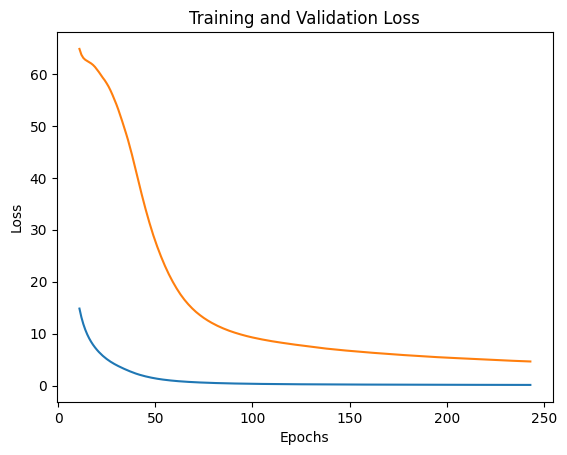

In [27]:
from matplotlib.pylab import plt

epochs = range(11, 244)

plt.plot(epochs, train_loss_list[10:], label='Training Loss')
plt.plot(epochs, eval_loss_list[10:], label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [28]:
torch.save(model.state_dict(), 'models/regression2k(150_50_50)_3layers.pt')

In [9]:
model = testModel(4, 4).to(device)
model.load_state_dict(torch.load('models/regression(100_50_50).pt'))

<All keys matched successfully>

In [29]:
def save_res(file_name, out):
    doc = minidom.parse(file_name)
    for i in out:
        tmp = []
        tmp.append('M')
        
        tmp.append(str(i[0]))
        tmp.append(str(i[1]))
        tmp.append("Q")
        tmp.append(str(i[4]))
        tmp.append(str(i[5]))
        tmp.append(str(i[2]))
        tmp.append(str(i[3]))
        x = doc.createElement("path")
        x.setAttribute("d" , " ".join(tmp))
        x.setAttribute("stroke" , "red")
        x.setAttribute("fill" , "none")
        doc.childNodes[0].appendChild(x)
    
    doc.writexml(open(join("res", file_name[-37:-4] + "_res.svg"), 'w'))

In [30]:
names = onlyfiles_pants[:200] + onlyfiles_skirt[:200]

for name in names:
    a = get_data_from_spec(name)
    data = torch.tensor(a[0]).to(torch.float).to(device)
    edge_index = torch.tensor(a[1]).to(device).permute(1,0)
    
    out = model(data, edge_index)
    out = out.tolist()

    out = backto6(name, out, a[2])

    save_res(name,out)